In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import model.sdes as sdes
import model.generate as generate
import model.graph_net as graph_net
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0]
branch_defs = [((0,), 0, 1)]

In [4]:
dataset = molecule_dataset.ZINCDataset()

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
class VarianceExplodingSDE(sdes.SDE):
    
    def __init__(self, sigma_min, sigma_max, input_shape):
        super().__init__(input_shape)
        
        self.sigma_min = torch.tensor(sigma_min).to(DEVICE)
        self.sigma_max = torch.tensor(sigma_max).to(DEVICE)
        
    def drift_coef_func(self, xt, t):
        return torch.zeros_like(xt)
    
    def diff_coef_func(self, xt, t):
        return self._inflate_dims(
            self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t) *
            torch.sqrt(2 * torch.log(self.sigma_max / self.sigma_min))
        )

    def forward(self, x0, t, return_score=True):
        z = torch.normal(torch.zeros_like(x0), torch.ones_like(x0))
        std = self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t)
        std = self._inflate_dims(std)
        xt = x0 + (std * z)
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        
    def mean_score_mag(self, t):
        variance = torch.square(self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t))
        return 1 / variance
        
    def sample_prior(self, num_sample, t):
        shape = torch.Size([num_sample]) + torch.Size(self.input_shape)
        z = torch.normal(torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE))
        std = self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t)
        return z * self._inflate_dims(std)

In [7]:
class AXJointSDE(sdes.SDE):
    
    def __init__(self, vp_beta_0, vp_beta_1, ve_sigma_min, ve_sigma_max, input_shape):
        super().__init__(input_shape)
        
        self.adj_shape = (input_shape[0], input_shape[0])
        self.x_shape = (input_shape[0], input_shape[1] - input_shape[0])
        
        self.adj_sde = VarianceExplodingSDE(ve_sigma_min, ve_sigma_max, self.adj_shape)
        self.x_sde = sdes.VariancePreservingSDE(vp_beta_0, vp_beta_1, self.x_shape)
        
    def forward(self, x0, t, return_score=True):
        adj_x0, x_x0 = x0[:, :, :x0.shape[1]], x0[:, :, x0.shape[1]:]
        if return_score:
            adj_xt, adj_score = self.adj_sde.forward(adj_x0, t, True)
            x_xt, x_score = self.x_sde.forward(x_x0, t, True)
            xt = torch.cat([adj_xt, x_xt], dim=2)
            score = torch.cat([adj_score, x_score], dim=2)
            return xt, score
        else:
            adj_xt = self.adj_sde.forward(adj_x0, t, False)
            x_xt = self.x_sde.forward(x_x0, t, False)
            return torch.cat([adj_xt, x_xt], dim=2)
        
    def mean_score_mag(self, t):
        adj_mag = self._inflate_dims(self.adj_sde.mean_score_mag(t))
        x_mag = self._inflate_dims(self.x_sde.mean_score_mag(t))
        adj_mag = torch.tile(adj_mag, (1,) + self.adj_shape)
        x_mag = torch.tile(x_mag, (1,) + self.x_shape)
        return torch.cat([adj_mag, x_mag], dim=2)
        
    def sample_prior(self, num_samples, t):
        adj_prior = self.adj_sde.sample_prior(num_samples, t)
        x_prior = self.x_sde.sample_prior(num_samples, t)
        return torch.cat([adj_prior, x_prior], dim=2)

In [8]:
# Create the SDE and model
sde = AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

model = graph_net.GraphJointNetwork(len(branch_defs), t_limit).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_nobranch"
import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

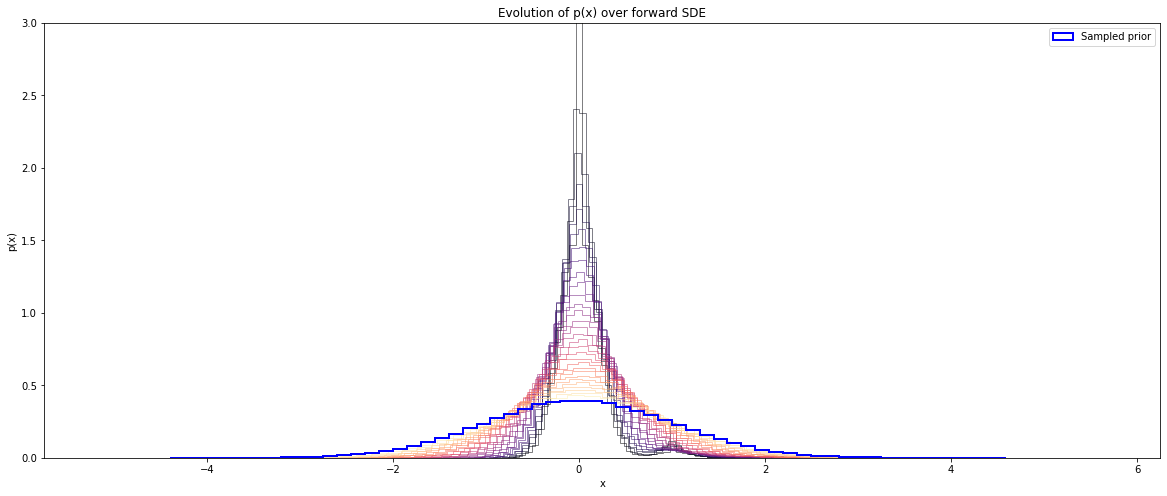

In [9]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [10]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 50,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "6"
Loss: 169.08: 100%|██████████████████████████████████| 1949/1949 [19:36<00:00,  1.66it/s]


Epoch 1 average Loss: 267.45


Loss: 133.95: 100%|██████████████████████████████████| 1949/1949 [19:36<00:00,  1.66it/s]


Epoch 2 average Loss: 149.99


Loss: 143.21: 100%|██████████████████████████████████| 1949/1949 [19:38<00:00,  1.65it/s]


Epoch 3 average Loss: 137.57


Loss: 126.67: 100%|██████████████████████████████████| 1949/1949 [19:40<00:00,  1.65it/s]


Epoch 4 average Loss: 131.27


Loss: 133.90: 100%|██████████████████████████████████| 1949/1949 [19:41<00:00,  1.65it/s]


Epoch 5 average Loss: 126.12


Loss: 124.98: 100%|██████████████████████████████████| 1949/1949 [19:40<00:00,  1.65it/s]


Epoch 6 average Loss: 123.67


Loss: 140.24: 100%|██████████████████████████████████| 1949/1949 [19:37<00:00,  1.65it/s]


Epoch 7 average Loss: 120.97


Loss: 106.73: 100%|██████████████████████████████████| 1949/1949 [19:18<00:00,  1.68it/s]


Epoch 8 average Loss: 119.14


Loss: 112.80: 100%|██████████████████████████████████| 1949/1949 [19:08<00:00,  1.70it/s]


Epoch 9 average Loss: 117.60


Loss: 119.89: 100%|██████████████████████████████████| 1949/1949 [18:42<00:00,  1.74it/s]


Epoch 10 average Loss: 116.23


Loss: 114.49: 100%|██████████████████████████████████| 1949/1949 [19:01<00:00,  1.71it/s]


Epoch 11 average Loss: 115.55


Loss: 103.70:  26%|█████████▏                         | 513/1949 [05:09<14:27,  1.66it/s]
WARNING - train - Aborted after 3:39:00!


KeyboardInterrupt: 

### Show generated distributions

In [11]:
ATOM_COLORS = {
    "C": "gray",
    "O": "lightcoral",
    "N": "royalblue"
}
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]

def plot_molecule(mol_graph):
    colors, symbols = [], {}
    for node in mol_graph.nodes():
        symbol_index = np.where(mol_graph.nodes[node]["feats"])[0][0]
        symbol = ATOM_SYMBOLS[symbol_index]
        try:
            colors.append(ATOM_COLORS[symbol])
        except KeyError:
            colors.append("violet")
        symbols[node] = symbol
    nx.draw(
        mol_graph,
        pos=nx.nx_pydot.graphviz_layout(mol_graph),
        labels=symbols,
        with_labels=True,
        node_color=colors,
        node_size=500
    )
    plt.show()

In [12]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.30it/s]


In [13]:
# Convert to NetworkX graphs
graph_samples = {}
for class_to_sample in classes:
    samps = samples[class_to_sample]
    s = samps.shape[1]
    adjs, xs = samps[:, :, :s], samps[:, :, s:]
    for i in range(len(samps)):
        adj, x = adjs[i], xs[i]

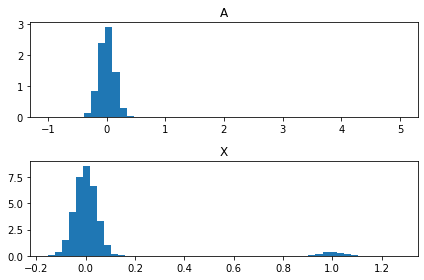

In [14]:
fig, ax = plt.subplots(nrows=2)
ax[0].hist(np.ravel(adjs), bins=np.linspace(-1, 5, 50), density=True)
ax[1].hist(np.ravel(xs), bins=50, density=True)
ax[0].set_title("A")
ax[1].set_title("X")
fig.tight_layout()
plt.show()

In [ ]:
# # Plot some randomly generated graphs
# for i, g in enumerate(graphs[:20]):
#     print(i)
#     plot_molecule(g)

In [15]:
data, y = next(iter(data_loader))
adj, x = data[:, :, :data.shape[1]], data[:, :, data.shape[1]:]

In [21]:
graph_net.node_flags(adj)[1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')